In [1]:
# coding: utf-8

"""Visualization of the transforms in data_loading.py"""
# **Author**: `Francisco Belchí <frbegu@gmail.com>, <https://github.com/KikoBelchi/2d_to_3d>`_



# Here we will compute
# normalize_xyz_min = [x_min, y_min, z_min], 
# where x_min corresponds to the minimum of the X 3D coordinate of all the vertices of within the training set.





###
### Imports
###
from __future__ import print_function, division
import itertools
import os
import torch
import pandas as pd
from skimage import io, transform # package 'scikit-image'
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import functions from data_loading and other scripts
import data_loading
import transfer_learning_TowelWall
from functions_data_processing import find_min_max_xyz_training, find_min_max_xyz_training_wo_outliers


# Imports for plotting
import matplotlib.pyplot as plt # Do not use when running on the server
from mpl_toolkits.mplot3d import axes3d # Do not use when running on the server

# Allow the interactive rotation of 3D scatter plots in jupyter notebook
import sys    
import os    
file_name =  os.path.basename(sys.argv[0])
#print(file_name == 'ipykernel_launcher.py') # This basicaly asks whether this file is a jupyter notebook?
if __name__ == "__main__":
    if file_name == 'ipykernel_launcher.py': # Run only in .ipynb, not in exported .py scripts
        get_ipython().run_line_magic('matplotlib', 'notebook') # Equivalent to ''%matplotlib notebook', but it is also understood by .py scripts


Cuda device = cpu


In [2]:
crop_centre_or_ROI = 1
sequence_name = 'TowelWall'
dataset_number='2'
camera_coordinates=1
reordered_dataset=1
submesh_num_vertices_vertical=2
submesh_num_vertices_horizontal=3
num_selected_vertices = submesh_num_vertices_vertical*submesh_num_vertices_horizontal # dummy variable if reordered_dataset==1
num_groups = 40
num_animationFramesPerGroup=99
batch_size=4
num_workers=4
random_seed_to_choose_video_sequences = 1
random_seed_to_shuffle_training_frames = 2
random_seed_to_shuffle_validation_frames = 3

In [3]:
if crop_centre_or_ROI==0: # centre crop
    transform = transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])
                                   ])    
elif crop_centre_or_ROI==1: # Region of interest. Bounding box containing the towel
    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])
                                   ])  

transformed_dataset = data_loading.vertices_Dataset(sequence_name = sequence_name, 
                                                    dataset_number = dataset_number,
                                                    transform=transform,
                                                    camera_coordinates=camera_coordinates,
                                                    crop_centre_or_ROI=crop_centre_or_ROI,
                                                    reordered_dataset = reordered_dataset,
                                                    num_vertices=num_selected_vertices,
                                                    submesh_num_vertices_vertical = submesh_num_vertices_vertical,
                                                    submesh_num_vertices_horizontal = submesh_num_vertices_horizontal)

print('Length of transformed_dataset (without including data augmentation):', len(transformed_dataset))

Length of transformed_dataset (without including data augmentation): 3960


In [4]:
###
### Training/validation split using random seeds for reproducing it below
###
# Randomly splitting sequences into train/val, 
# and then randomizing the ordering of all frames of all sequences in 'train' and doing the same with 'val'.
# Every random choice has a seed for reproducibility.
if __name__ == "__main__":
#     print('num_groups =', num_groups)
#     print('num_animationFramesPerGroup =', num_animationFramesPerGroup)
    
    [transformed_dataset_train, transformed_dataset_val] = data_loading.random_split_notMixingSequences( 
        transformed_dataset, num_groups = num_groups, 
        num_animationFramesPerGroup = num_animationFramesPerGroup,
        random_seed_to_choose_video_sequences = random_seed_to_choose_video_sequences,
        random_seed_to_shuffle_training_frames = random_seed_to_shuffle_training_frames,
        random_seed_to_shuffle_validation_frames = random_seed_to_shuffle_validation_frames)

    dataset_sizes = {'train': len(transformed_dataset_train),
                    'val': len(transformed_dataset_val)}
    print('Length of transformed_dataset:', len(transformed_dataset))
    print('Length of transformed_dataset_train:', dataset_sizes['train'])
    print('Length of transformed_dataset_val:', dataset_sizes['val'])
   
    dataloaders = {'train': DataLoader(transformed_dataset_train, batch_size=batch_size,
                                       shuffle=True, num_workers=num_workers),
                   'val': DataLoader(transformed_dataset_val, batch_size=batch_size, 
                                     shuffle=True, num_workers=num_workers)}

Training sequences: [6, 37, 13, 18, 12, 19, 14, 31, 24, 35, 1, 36, 25, 40, 7, 8, 23, 33, 21, 11, 16, 2, 20, 17, 5, 32, 39, 28, 34, 29, 27, 30]
Validation sequences: [15, 4, 3, 9, 26, 38, 10, 22]

Length of transformed_dataset: 3960
Length of transformed_dataset_train: 3168
Length of transformed_dataset_val: 792


# Find the min and max values with which to normalize the x, y, z world/camera coordinates 
### (in this case, camera, because we instanciated the dataset with camera_coordinates=1)

In [ ]:
# if __name__ == "__main__":
#     x_min, y_min, z_min, x_max, y_max, z_max = find_min_max_xyz_training(dataloaders)
#     print("%8.2f %8.2f %8.2f %8.2f %8.2f %8.2f" % (x_min, y_min, z_min, x_max, y_max, z_max))

# Try to apply min and max normalization to the x, y, z coordinates of the whole instantiation of the dataset
### It does not work, so create instead in transfer_learning_TowelWall.py a new dataset in which the normalization found is applied and then make the same train/val split

In [ ]:
# def apply_min_max_xyz_normalization(dataloaders, x_min, y_min, z_min, x_max, y_max, z_max):
#     for i_batch, sample_batched in enumerate(dataloaders['train']):
#         sample_batched['Vertex_coordinates'][:,:,0]=(sample_batched['Vertex_coordinates'][:,:,0]-x_min)/(x_max-x_min)
#         sample_batched['Vertex_coordinates'][:,:,1]=(sample_batched['Vertex_coordinates'][:,:,1]-y_min)/(y_max-y_min)
#         sample_batched['Vertex_coordinates'][:,:,2]=(sample_batched['Vertex_coordinates'][:,:,2]-z_min)/(z_max-z_min)
#     return dataloaders # I tried both returning this and not returning anything and it didn't work either way

# if __name__ == "__main__":
#     dataloaders=apply_min_max_xyz_normalization(dataloaders, x_min, y_min, z_min, x_max, y_max, z_max)
    
#     # Check if it worked
#     x_min, y_min, z_min, x_max, y_max, z_max = find_min_max_xyz_training(dataloaders)
#     print("If it worked, this should be 0, 0, 0, 1, 1, 1: \n%8.2f %8.2f %8.2f %8.2f %8.2f %8.2f" % (x_min, y_min, z_min, x_max, y_max, z_max))

# Apply the normalization 0<=x,y,z<=1 to the whole dataset via a new instantiation of new dataset class vertices_normalized_Dataset in data_loading after having checked the 3D coordinates of the training set.

In [ ]:
if __name__ == "__main__":
    x_min, y_min, z_min, x_max, y_max, z_max = find_min_max_xyz_training(dataloaders)
    print("%8.2f %8.2f %8.2f %8.2f %8.2f %8.2f" % (x_min, y_min, z_min, x_max, y_max, z_max))
    normalize_xyz_min = [x_min, y_min, z_min]
    normalize_xyz_max = [x_max, y_max, z_max]
    
    normalized_transformed_dataset = data_loading.vertices_normalized_Dataset(normalize_xyz_min=normalize_xyz_min,
                                                                          normalize_xyz_max=normalize_xyz_max,
                                                                          sequence_name = sequence_name,
                                                                          dataset_number = dataset_number,
                                                                          transform=transform,
                                                                          camera_coordinates=camera_coordinates,
                                                                          crop_centre_or_ROI=crop_centre_or_ROI,
                                                                          reordered_dataset = reordered_dataset,
                                                                          num_vertices=num_selected_vertices,
                                                                          submesh_num_vertices_vertical = submesh_num_vertices_vertical,
                                                                          submesh_num_vertices_horizontal = submesh_num_vertices_horizontal)

    print('Length of normalized_transformed_dataset (without including data augmentation):', len(normalized_transformed_dataset))

In [ ]:
###
### Training/validation split using the random seeds from above
###
if __name__ == "__main__":
    [normalized_transformed_dataset_train, normalized_transformed_dataset_val] = data_loading.random_split_notMixingSequences( 
        normalized_transformed_dataset, num_groups = num_groups, 
        num_animationFramesPerGroup = num_animationFramesPerGroup,
        random_seed_to_choose_video_sequences = random_seed_to_choose_video_sequences,
        random_seed_to_shuffle_training_frames = random_seed_to_shuffle_training_frames,
        random_seed_to_shuffle_validation_frames = random_seed_to_shuffle_validation_frames)

    normalized_dataset_sizes = {'train': len(normalized_transformed_dataset_train),
                    'val': len(normalized_transformed_dataset_val)}
    print('Length of normalized_transformed_dataset:', len(normalized_transformed_dataset))
    print('Length of normalized_transformed_dataset_train:', normalized_dataset_sizes['train'])
    print('Length of normalized_transformed_dataset_val:', normalized_dataset_sizes['val'])
    
    normalized_dataloaders = {'train': DataLoader(normalized_transformed_dataset_train, batch_size=batch_size,
                                       shuffle=True, num_workers=num_workers),
                   'val': DataLoader(normalized_transformed_dataset_val, batch_size=batch_size, 
                                     shuffle=True, num_workers=num_workers)}

### Checking that it worked

In [ ]:
if __name__ == "__main__":
    x_min, y_min, z_min, x_max, y_max, z_max = find_min_max_xyz_training(normalized_dataloaders)
    print("%8.2f %8.2f %8.2f %8.2f %8.2f %8.2f" % (x_min, y_min, z_min, x_max, y_max, z_max))

# Normalization 0<=x,y,z<=1 to the whole dataset using the (non-outlier values of) min and max of each observation in the training set.

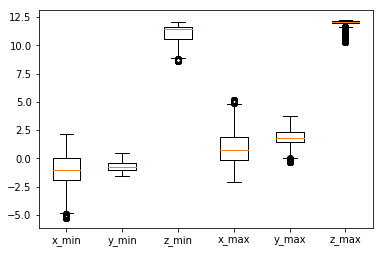

   -5.27    -1.54    10.02     5.16     3.75    12.22
Length of normalized_transformed_dataset (without including data augmentation): 3960


In [5]:
if __name__ == "__main__":
    x_min, y_min, z_min, x_max, y_max, z_max = find_min_max_xyz_training_wo_outliers(dataloaders, boxplot_on=1)
    print("%8.2f %8.2f %8.2f %8.2f %8.2f %8.2f" % (x_min, y_min, z_min, x_max, y_max, z_max))
    normalize_xyz_min = [x_min, y_min, z_min]
    normalize_xyz_max = [x_max, y_max, z_max]
    
    normalized_transformed_dataset = data_loading.vertices_normalized_Dataset(normalize_xyz_min=normalize_xyz_min,
                                                                          normalize_xyz_max=normalize_xyz_max,
                                                                          sequence_name = sequence_name,
                                                                          dataset_number = dataset_number,
                                                                          transform=transform,
                                                                          camera_coordinates=camera_coordinates,
                                                                          crop_centre_or_ROI=crop_centre_or_ROI,
                                                                          reordered_dataset = reordered_dataset,
                                                                          num_vertices=num_selected_vertices,
                                                                          submesh_num_vertices_vertical = submesh_num_vertices_vertical,
                                                                          submesh_num_vertices_horizontal = submesh_num_vertices_horizontal)

    print('Length of normalized_transformed_dataset (without including data augmentation):', len(normalized_transformed_dataset))

x_min, y_min, z_min, x_max, y_max, z_max<br>
With outliers:<br>
    -5.27    -1.54     8.62     5.16     3.75    12.22 <br>
Removing outliers:<br>
    -5.27    -1.54    10.02     5.16     3.75    12.22

In [6]:
###
### Training/validation split using the random seeds from above
###
if __name__ == "__main__":
    [normalized_transformed_dataset_train, normalized_transformed_dataset_val] = data_loading.random_split_notMixingSequences( 
        normalized_transformed_dataset, num_groups = num_groups, 
        num_animationFramesPerGroup = num_animationFramesPerGroup,
        random_seed_to_choose_video_sequences = random_seed_to_choose_video_sequences,
        random_seed_to_shuffle_training_frames = random_seed_to_shuffle_training_frames,
        random_seed_to_shuffle_validation_frames = random_seed_to_shuffle_validation_frames)

    normalized_dataset_sizes = {'train': len(normalized_transformed_dataset_train),
                    'val': len(normalized_transformed_dataset_val)}
    print('Length of normalized_transformed_dataset:', len(normalized_transformed_dataset))
    print('Length of normalized_transformed_dataset_train:', normalized_dataset_sizes['train'])
    print('Length of normalized_transformed_dataset_val:', normalized_dataset_sizes['val'])
    
    normalized_dataloaders = {'train': DataLoader(normalized_transformed_dataset_train, batch_size=batch_size,
                                       shuffle=True, num_workers=num_workers),
                   'val': DataLoader(normalized_transformed_dataset_val, batch_size=batch_size, 
                                     shuffle=True, num_workers=num_workers)}

Training sequences: [6, 37, 13, 18, 12, 19, 14, 31, 24, 35, 1, 36, 25, 40, 7, 8, 23, 33, 21, 11, 16, 2, 20, 17, 5, 32, 39, 28, 34, 29, 27, 30]
Validation sequences: [15, 4, 3, 9, 26, 38, 10, 22]

Length of normalized_transformed_dataset: 3960
Length of normalized_transformed_dataset_train: 3168
Length of normalized_transformed_dataset_val: 792


### Checking that it worked

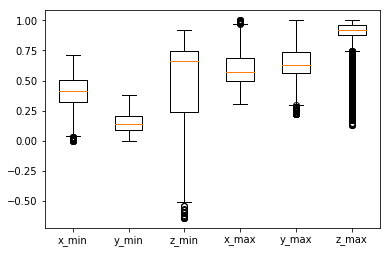

    0.00     0.00     0.00     1.00     1.00     1.00


In [8]:
if __name__ == "__main__":
    x_min, y_min, z_min, x_max, y_max, z_max = find_min_max_xyz_training_wo_outliers(normalized_dataloaders, boxplot_on=1)
    print("%8.2f %8.2f %8.2f %8.2f %8.2f %8.2f" % (x_min, y_min, z_min, x_max, y_max, z_max))